# __Calculs de séries temporelles moyennées sur plusieurs bassins versants à partir de centaines de milliers de grilles ERA5 et ERA5-Land stockées sur le cloud....le tout en quelques secondes!__

Ce bloc-note présente une stratégie pour calculer des séries temporelles moyennées à un bassin versant (représenté par un fichier de polygone de type geojson ou shapefile) à partir de centaines de milliers de grilles (telles que la température, le vent, les précipitations, la neige au sol , la couverture de nuages, la radiation nette au sol, ainsi que des dizaines d'autres variables) stockées sur le cloud. Plus spécifiquement, les données de réanalyse ERA5 et ERA5-Land, disponibles pour la zone du Québec, de l'Ontario et du nord-est des États-Unis, et dont la taille fait 2.3 TB seront analysés, le tout en quelques secondes seulement.

Comment est-il possible d'atteindre cet objectif? __Tout simplement en évitant de télécharger 2.3TB vers notre ordinateur local (ce qui prendrait des jours) et en profitant des nouveaux formats de stockages de données de grilles (zarr, tileDB, geotiff) optimisés pour l'infonuagique.__ Pour cet exemple, les données ERA5 et ERA5-Land sont disponibles en format zarr.

Notez que ce bloc-note peut être exécuté sur un poste local avec les configurations et l'environnement adéquat ou alors dans le cloud. Cet exemple est originalement exécuté sur une seule machine virtuelle dans le cloud, mais pourrait être facilement exécutée sur un cluster de centaines de coeurs si requis, notamment avec l'orchestrateur de conteneurs Kubernetes. Pour plus d'informations sur l'environnement requis (lorsque python est utilisé) :

https://github.com/sebastienlanglois/zarr-experiments/blob/master/binder/environment.yml 

Pour exécuter une cellule, il suffit de cliquer sur une cellule puis appuyer sur Shift+Enter. Notez que les cellules doivent être exécutées dans l'ordre de haut en bas pour assurer la cohérence dans l'exécution.

__Précisions techniques (*pour les intéressé(e)s*) :__

- Zarr : https://zarr.readthedocs.io/en/stable/

Zarr est une librairie qui permet de partitionner et compresser efficacement des matrices de dimensions N. Le format zarr a été testé avec succès sur des jeux de données de l'ordre du PB (petabytes). Il existe aujourd'hui beaucoup de grands jeux de données (TBs, PBs) qui sont disponibles en format zarr gratuitement (CMIP6, ERA5, TRMM, GMET, HydroSheds, etc.) et il est prévu que d'ici 2025, 350 PB de données de grilles seront importées dans le cloud, par la NASA seulement! Par ailleurs, il existe des wrappers et librairies dans plusieurs languages de programmation pour accéder à zarr (Julia, R, C++, Python).

- Dask : https://dask.org/

Dask est une librairie qui permet de planifier et optimiser les tâches à exécuter (lazy loading) puis de distribuer le calcul sur les coeurs disponibles sur une machine ou un cluster. Dask s'apparente à Spark et est utilisé pour traiter, distribuer et analyser des volumes de données importants (TB). Dask est compatible avec d'autres librairies typiques de python (pandas, numpy, scipy, tensorflow, etc.)

- Xarray : http://xarray.pydata.org/en/stable/

Xarray est une librarie reposant sur Dask qui permet d'analyser et de traiter des matrices de dimensions N avec des métadonnées (coordonnées, temps, etc.). Xarray propose aussi plusieurs apis pour interagir avec plusieurs types de format classiques dans le domaine géospatial (netcdf, grib, geotiff, ascii, csv (xyz), zarr, etc).


Date: Janvier 19, 2020

Créé par : Sébastien Langlois

In [3]:
# Librairies nécessaires
import xarray as xr
import geopandas as gpd
import fsspec
import numpy as np
from rasterio import features
from affine import Affine
import pandas as pd
import hydrotools as ht
import os
import matplotlib.pyplot as plt
import warnings
import s3fs
from distributed import Client, progress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Client Dask
Mise en oeuvre d'un client dask qui permet de planifier (lazy loading) et paralléliser les processus/threads entre les coeurs d'une machine seule ou d'un cluster, selon le cas. Compatible avec un orchestrateurs de conteneurs, par exemple Kubernetes, si requis.

![title](img/grid_search_schedule.gif)

In [4]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:41953 Dashboard: http://127.0.0.1:42987/status,Cluster Workers: 4 Cores: 12 Memory: 33.53 GB


# Repertoires

In [28]:
# Repertoire contenant les geojson (équivalent à des polygones de type "shapefile", mais accessible en un seul fichier)
polygon_files = 's3://watersheds-polygons/MELCC/json'

# Nom du bucket contenant les donnees ERA5-Land
bucket_era5 ='s3://era5-atlantic-northeast/zarr/single-levels/reanalysis'
bucket_era5_land ='s3://era5-atlantic-northeast/zarr/land/reanalysis'


# Configs

In [6]:
# Url du serveur contenant le bucket
client_kwargs={"endpoint_url":"https://s3.us-east-2.wasabisys.com"}

# Geopandas

Geopandas permet de lire un ou plusieurs fichiers contenant des polygones (geojson, shapefiles, etc.), de présenter les métadonnées sous forme de dataframe (tableau) et d'interagir avec celles-ci

In [7]:
# Shapefiles/json to geopandas
gdf = ht.files_to_gdf(url=polygon_files,
                      client_kwargs=client_kwargs)  
gdf

,Station,Superficie,geometry
0,010101,528.9212895883302,"POLYGON ((-64.53947 48.47196, -64.55402 48.471..."
1,010801,2107.342460195889,"POLYGON ((-65.62631 48.24497, -65.62631 48.244..."
2,010802,1881.890875431939,"POLYGON ((-65.28353 48.29449, -65.28353 48.294..."
3,010901,1411.600105724913,"POLYGON ((-66.03836 48.61113, -66.03726 48.611..."
4,010902,1338.044040943107,"POLYGON ((-65.70894 48.20129, -65.70894 48.201..."
...,...,...,...
732,104401,3679.506417512327,"POLYGON ((-66.41518 57.90217, -66.39053 57.907..."
733,104801,34894.98869165544,"POLYGON ((-65.76932 57.68900, -65.76972 57.689..."
734,104803,22977.4240842765,"POLYGON ((-64.13857 56.70662, -64.13885 56.706..."
735,104804,5896.396912120486,"POLYGON ((-65.10647 54.96131, -65.10647 54.961..."


Par exemple, visualisons les polygones ci-dessous :

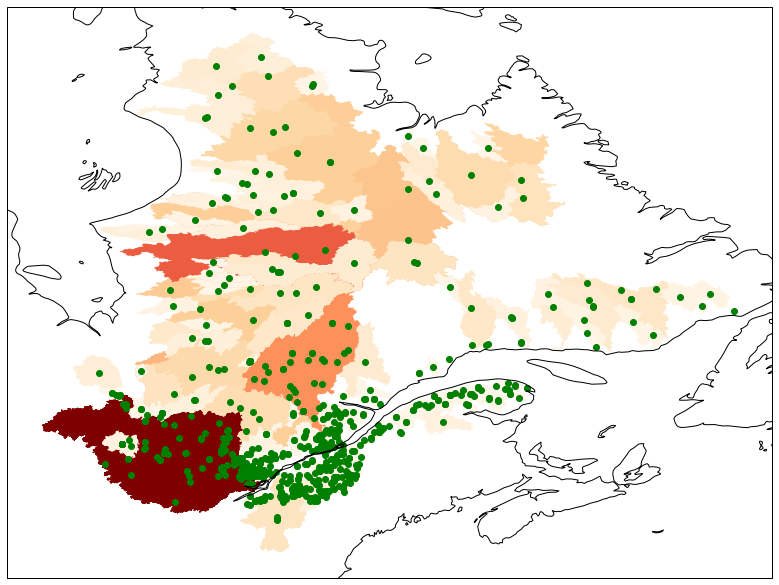

In [25]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
gdf.plot(column=gdf['Superficie'].astype('float'),cmap='OrRd', ax=ax)
gdf['geometry'].centroid.plot(ax=ax, color='green')


# Xarray Dataset
![title](img/dataset-diagram.png)

# ERA5
21 variables ERA5 sont disponibles dans le bucket. Leurs métadonnées peuvent être brièvement consultées ci-dessous.


In [29]:
#Mapping vers filesystem depuis le bucket
store = fsspec.get_mapper(url=bucket_era5,
                          client_kwargs=client_kwargs,
                          anon=True)

# Ouverture du zarr vers dataset (xarray)
ds_era5 = xr.open_zarr(store,
                       consolidated=True,
                       chunks='auto')
ds_era5

<xarray.Dataset>
Dimensions:    (latitude: 93, longitude: 177, time: 357936)
Coordinates:
  * latitude   (latitude) float32 63.0 62.75 62.5 62.25 ... 40.5 40.25 40.0
  * longitude  (longitude) float32 -96.0 -95.75 -95.5 ... -52.5 -52.25 -52.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2019-10-31T23:00:00
Data variables:
    cp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    csf        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    d2m        (time, latitude, longitude) float64 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    lsf        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    lsp        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    mn2t       (time, latitude, longitude) float64 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    mx2t       (time, latitude, longitude) float64 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    ptype      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sd         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sf         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    t2m        (time, latitude, longitude) float64 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tcc        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tcrw       (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tsn        (time, latitude, longitude) float64 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-18 22:35:29 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

1- Vérifions que les données sont bel et bien accessibles. Prenons par exemple la variable tp (total precipitation) pour l'année 1981 et la coordonnée (50,-70) :

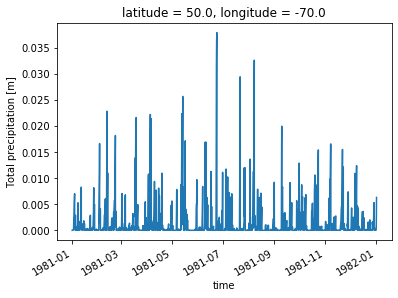

In [17]:
(ds.tp.sel(latitude=50, 
            longitude=-70,
            time=slice('1981-01-01', '1982-01-01'))).plot()

2- Vérifions que les données sont bel et bien accessibles. Prenons la grille de la variable sd (EEN) pour à 2019-01-01T01:00:00 :

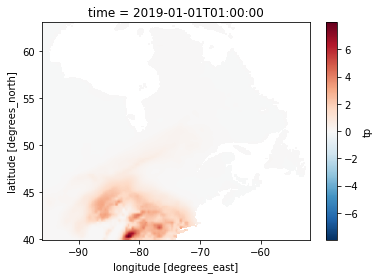

In [22]:
# *1000 pour convertir de mètres vers millimètres
(ds.tp.sel(time='2019-01-01T01:00:00')*1000).plot()

Pour plus d'informations sur les variables disponibles :

In [10]:
# ds.variables

# ERA5-Land

In [31]:
#Mapping vers filesystem depuis le bucket
store = fsspec.get_mapper(url=bucket_era5_land,
                          client_kwargs=client_kwargs,
                          anon=True)

# Ouverture du zarr vers dataset (xarray)
ds_era5_land = xr.open_zarr(store,
                            consolidated=True,
                            chunks='auto')
ds_era5_land

<xarray.Dataset>
Dimensions:    (latitude: 231, longitude: 441, time: 339648)
Coordinates:
  * latitude   (latitude) float32 63.0 62.9 62.8 62.7 ... 40.3 40.2 40.1 40.0
  * longitude  (longitude) float32 -96.0 -95.9 -95.8 -95.7 ... -52.2 -52.1 -52.0
  * time       (time) datetime64[ns] 1981-01-01 ... 2019-09-30T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    licd       (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sd         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sde        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sf         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    smlt       (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    snowc      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl2      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    swvl3      (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    tsn        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(8760, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-14 15:35:10 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

Prenons par exemple la variable sd (snow depth water equivalent) :

# Application des moyennes bassins (xarray vers dataframe)
Une fonction simple *clip_polygon_to_dataframe()* a été utilisée pour appliquer les grilles sur chacun des polygones préalablement définis dans le tableau plus haut (geopandas). Cette fonction permet également d'ajuster les fuseaux horaires et faire des opérations de réduction sur les matrices de données. Assumant que la bande passante soit d'au moins 200-300Mbit/s (ce qui est le cas dans le cloud), le calcul ne devrait pas prendre plus de 1-2 secondes par bassin en moyenne. Notons qu'il serait possible d'améliorer ce temps de calcul en optimisant la fonction *clip_polygon_to_dataframe()*

In [32]:
%%time

df_era5 = ht.clip_polygon_to_dataframe(dataset=ds_era5,
                                       geodataframe=gdf[0:10], # prendre seulement les 10 premiers pour fin de tests
                                       geodf_index_column='Station',
                                       variable='tp',  
                                       aggregation='sum',
                                       resample_time='1D', # originalement au pas de temps horaire
                                       from_tz='UTC',
                                       to_tz='America/Montreal',
                                       latlng_names=['latitude',
                                                    'longitude']
                                       )
# Convertir vers le format fin de pas de temps
# df.index = df.index.tz_convert(None).normalize() + pd.DateOffset(days=1)

010101
010801
010802
010901
010902
010903
011001
011002
011003
011201
CPU times: user 10.4 s, sys: 4.99 s, total: 15.4 s
Wall time: 1min 44s


In [33]:
%%time

df_era5_land = ht.clip_polygon_to_dataframe(dataset=ds_era5_land,
                                            geodataframe=gdf[0:10], # prendre seulement les 10 premiers pour fin de tests
                                            geodf_index_column='Station',
                                            variable='sd',  
                                            aggregation='mean',
                                            resample_time='1D', # originalement au pas de temps horaire
                                            from_tz='UTC',
                                            to_tz='America/Montreal',
                                            latlng_names=['latitude',
                                                        'longitude']
                                            )
# Convertir vers le format fin de pas de temps
# df.index = df.index.tz_convert(None).normalize() + pd.DateOffset(days=1)

010101
010801
010802
010901
010902
010903
011001
011002
011003
011201
CPU times: user 5.89 s, sys: 2.03 s, total: 7.92 s
Wall time: 36 s


# Dataframe (Tableau)

In [34]:
df_era5

,010101,010801,010802,010901,010902,010903,011001,011002,011003,011201
time,,,,,,,,,,
1978-12-31 00:00:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1979-01-01 00:00:00-05:00,0.010528,0.014628,0.014628,0.016127,0.016127,0.016127,0.013423,0.013819,0.013819,0.016225
1979-01-02 00:00:00-05:00,0.005663,0.009011,0.009011,0.010296,0.010296,0.010296,0.011432,0.011257,0.011257,0.015041
1979-01-03 00:00:00-05:00,0.017209,0.024311,0.024311,0.021687,0.021687,0.021687,0.020176,0.020322,0.020322,0.026687
1979-01-04 00:00:00-05:00,0.000765,0.000908,0.000908,0.000873,0.000873,0.000873,0.000885,0.000880,0.000880,0.000821
...,...,...,...,...,...,...,...,...,...,...
2019-10-27 00:00:00-04:00,0.000005,0.000001,0.000001,0.000003,0.000003,0.000003,0.000008,0.000008,0.000008,0.000045
2019-10-28 00:00:00-04:00,0.000657,0.001422,0.001422,0.001704,0.001704,0.001704,0.001985,0.001972,0.001972,0.003460
2019-10-29 00:00:00-04:00,0.000119,0.000187,0.000187,0.000361,0.000361,0.000361,0.000387,0.000430,0.000430,0.000471


In [35]:
df_era5_land

,010101,010801,010802,010901,010902,010903,011001,011002,011003,011201
time,,,,,,,,,,
1980-12-31 00:00:00-05:00,0.200388,0.192549,0.200122,0.200481,0.200481,0.200481,0.201567,0.201023,0.202529,0.182582
1981-01-01 00:00:00-05:00,0.200418,0.192620,0.200211,0.200649,0.200649,0.200649,0.201931,0.201318,0.202881,0.182643
1981-01-02 00:00:00-05:00,0.200752,0.193014,0.200603,0.201006,0.201006,0.201006,0.202185,0.201621,0.203143,0.183070
1981-01-03 00:00:00-05:00,0.209094,0.200167,0.207721,0.208061,0.208061,0.208061,0.209507,0.208929,0.210418,0.190702
1981-01-04 00:00:00-05:00,0.210371,0.201214,0.208806,0.209178,0.209178,0.209178,0.210929,0.210260,0.211819,0.191635
...,...,...,...,...,...,...,...,...,...,...
2019-09-26 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-09-27 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-09-28 00:00:00-04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Visualisation rapide

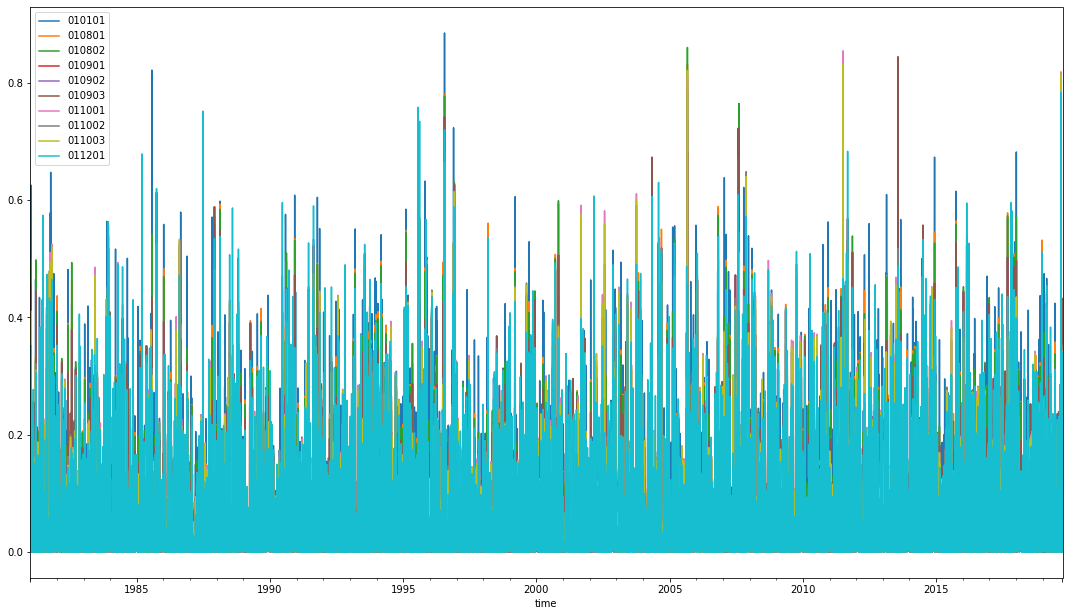

In [27]:
df_era5.plot()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
df_era5_land.plot()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

## Stockage des résultats et téléchargement localement

In [12]:
# Choisir un nom de fichier .csv pour sauvegarder les résultats :

nom_fichier_era5 = 'era5-cehq.csv'
nom_fichier_era5_land = 'era5-land-cehq.csv'

s3 = s3fs.S3FileSystem(client_kwargs=client_kwargs,
                               anon=True)  # public read

with s3.open('s3://analytics-store/' + nom_fichier_era5,'w') as f:
    df_era5.to_csv(f,
                   encoding='latin-1')
    
with s3.open('s3://analytics-store/' + nom_fichier_era5_land,'w') as f:
    df_era5_land.to_csv(f,
                        encoding='latin-1')

Les données peuvent être téléchargées à l'adresse suivante :
https://s3.us-east-2.wasabisys.com/analytics-store/ + nom_fichier
    
Par exemple, si nom_fichier = 'era5-land-cehq.csv', alors l'adresse serait :
https://s3.us-east-2.wasabisys.com/analytics-store/era5-land-cehq.csv

Pareillement, si nom_fichier = 'era5-land.csv', alors l'adresse serait :
https://s3.us-east-2.wasabisys.com/analytics-store/era5-cehq.csv

Notez que le fichier pourrait être détruit par d'autres utilisateurs dans le cloud après votre utilisation. Il est recommandé d'utiliser votre propre répertoire privé dans le cloud pour y télédéverser vos fichiers finaux ou télécharger immédiatement vos fichiers à partir des liens montrés ci-dessus.